# Scraping Internshala

*Disclaimer:This is purely for educational purpose.Scraping is legal as long as you dont take any confidential information from the site.I do not extract any copyrighted material.Respecting robot.txt norms*

## I'll be scraping internshala inorder to get  what most interns require as a skillset and will be displaying it as a wordcloud.I'll also be extracting stipend of paid interns and calculating mean/median stipend

In [8]:
#importing necessary libraries
from selenium import webdriver
import time
from bs4 import BeautifulSoup
import json
from wordcloud import WordCloud,STOPWORDS
import re
import requests
import matplotlib.pyplot as plt
import pandas as pd
import os
from IPython.display import Image

<span style='color:red'> I am using Selenium and Beautifulsoup inroder to scrape the website.The reason i used Selenium here because internshala website takes some time to load and just by using requests.get I was not able to get all the categories.Hence I used Selenium here at the starting and for rest of the scraping I'll be using requests library.</span>



## Extracting categories along with their links

In [3]:
base_url = 'https://internshala.com/internships/'

driver = webdriver.Chrome(os.environ.get('CDRIVE_PATH')) #path to chromedriver

driver.get(base_url)
#Sleeping so that the page loads and then i can copy the source code of the website.Alternatively WebdriverWait can be used but this is simple
time.sleep(2)

pagesource = driver.page_source
soup = BeautifulSoup(pagesource,'lxml')
driver.close()

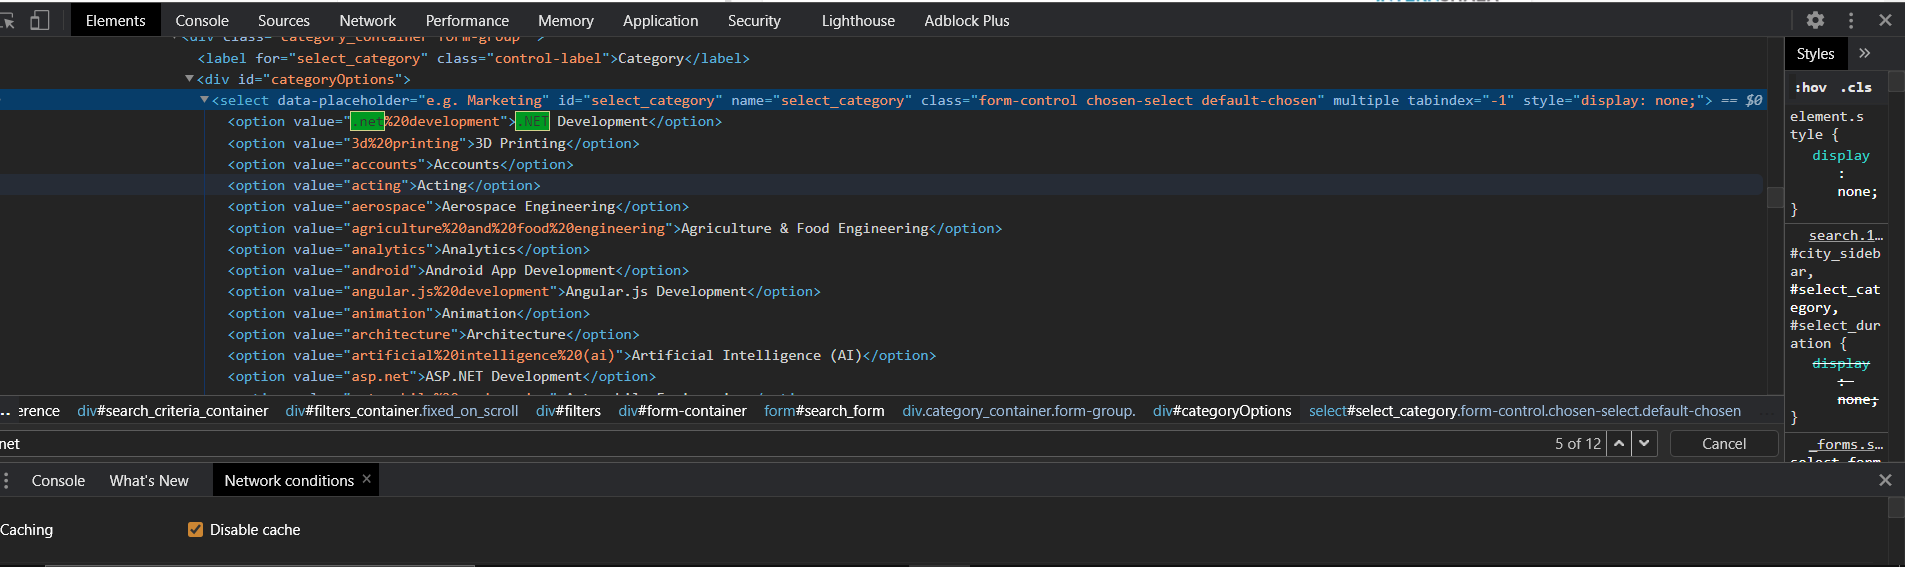

In [14]:
Image(data='1.png')

### select tag where id = 'select_category' has all options tag with value as to their respective links

In [15]:
for i in soup.find_all('select',{'id':'select_category'}):
    lst = i.find_all('option')
    
lst

[<option value=".net%20development">.NET Development</option>,
 <option value="3d%20printing">3D Printing</option>,
 <option value="accounts">Accounts</option>,
 <option value="acting">Acting</option>,
 <option value="aerospace">Aerospace Engineering</option>,
 <option value="agriculture%20and%20food%20engineering">Agriculture &amp; Food Engineering</option>,
 <option value="analytics">Analytics</option>,
 <option value="android">Android App Development</option>,
 <option value="angular.js%20development">Angular.js Development</option>,
 <option value="animation">Animation</option>,
 <option value="architecture">Architecture</option>,
 <option value="artificial%20intelligence%20(ai)">Artificial Intelligence (AI)</option>,
 <option value="asp.net">ASP.NET Development</option>,
 <option value="automobile%20engineering">Automobile Engineering</option>,
 <option value="backend%20development">Backend Development</option>,
 <option value="big%20data">Big Data</option>,
 <option value="bioinf

In [16]:
#Making a dictionary where key as category name and value as its link
data_dict = {}
for i in lst:
    data_dict.update({i.get_text():base_url + i.attrs['value']+'-internship'})
data_dict

{'.NET Development': 'https://internshala.com/internships/.net%20development-internship',
 '3D Printing': 'https://internshala.com/internships/3d%20printing-internship',
 'Accounts': 'https://internshala.com/internships/accounts-internship',
 'Acting': 'https://internshala.com/internships/acting-internship',
 'Aerospace Engineering': 'https://internshala.com/internships/aerospace-internship',
 'Agriculture & Food Engineering': 'https://internshala.com/internships/agriculture%20and%20food%20engineering-internship',
 'Analytics': 'https://internshala.com/internships/analytics-internship',
 'Android App Development': 'https://internshala.com/internships/android-internship',
 'Angular.js Development': 'https://internshala.com/internships/angular.js%20development-internship',
 'Animation': 'https://internshala.com/internships/animation-internship',
 'Architecture': 'https://internshala.com/internships/architecture-internship',
 'Artificial Intelligence (AI)': 'https://internshala.com/intern

In [6]:
data_dict['Web Development']

'https://internshala.com/internships/web%20development-internship'

### Extracting all intern links from the given category

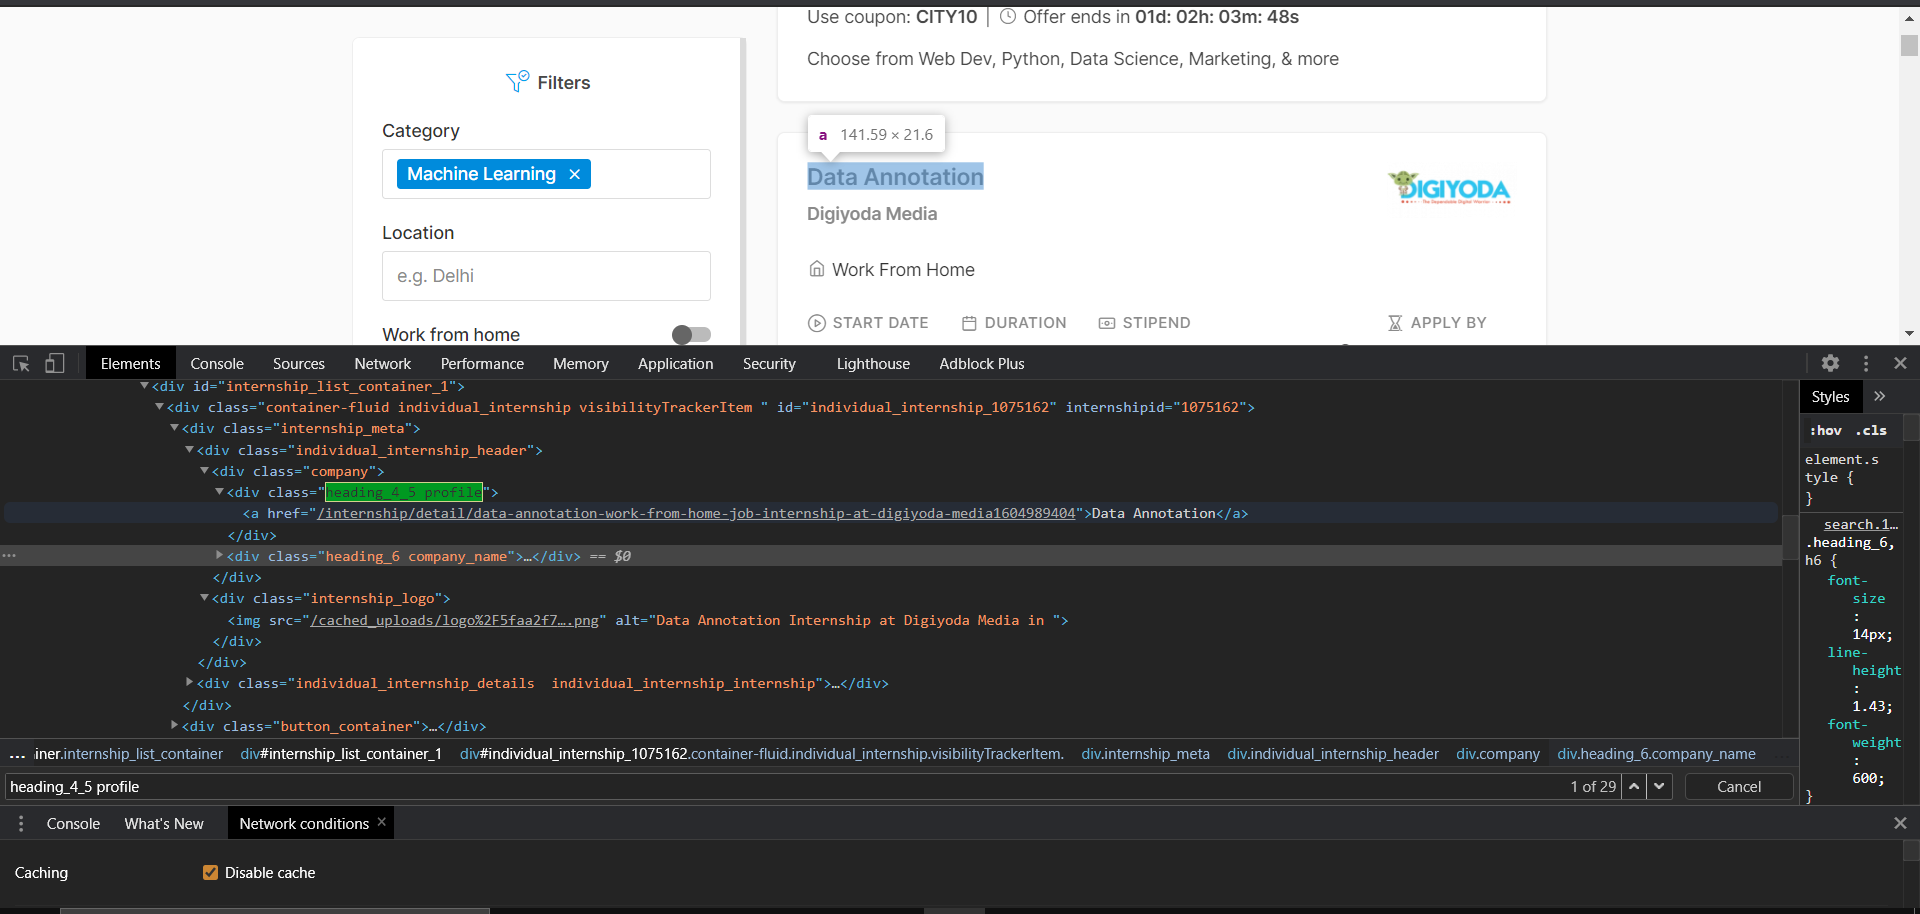

In [32]:
Image(data='2.png')

### div tag with class 'heading_4_5_profile' has the intern link

In [17]:
def get_intern_links(soup):
    links = []
    for link in soup.find_all('div',{'class': 'heading_4_5 profile'}):
        links.append('https://internshala.com' + link.find('a').get('href'))
    
    return links

In [23]:
#This functions takes care of pagination

def intern_links(cat_dict):
    '''
    Input:category link
    Output:list of available interns
    
    Given the input as category link, it will fetch all the available intern links and gives the list of same
    
    '''
    cont = requests.get(cat_dict)
    soup = BeautifulSoup(cont.text,'lxml')
    
    intern_links = get_intern_links(soup)
    
    if(pages := int(soup.find('span',{'id':'total_pages'}).get_text())) > 1: #checks if number of pages is more than 1
        for i in range(2,pages+1):
            data = requests.get(cat_dict+'/page-'+str(i))
            soup2 = BeautifulSoup(data.text,'lxml')
            intern_links.extend(get_intern_links(soup2))
        
    return intern_links

In [24]:
interns = intern_links(data_dict['Machine Learning'])

In [25]:
interns

['https://internshala.com/internship/detail/machine-learning-and-cloud-computing-work-from-home-job-internship-at-iit-bombay1604739017',
 'https://internshala.com/internship/detail/data-annotation-work-from-home-job-internship-at-digiyoda-media1604989404',
 'https://internshala.com/internship/detail/deep-learning-research-for-algo-trading-work-from-home-job-internship-at-crowd-wisdom-trading1604990864',
 'https://internshala.com/internship/detail/conversational-application-implementation-internship-in-bangalore-at-wizergos1604980249',
 'https://internshala.com/internship/detail/php-laravel-development-work-from-home-job-internship-at-job-vacancy-result1604928142',
 'https://internshala.com/internship/detail/machine-learning-work-from-home-job-internship-at-pikkal-company1604917043',
 'https://internshala.com/internship/detail/artificial-neural-networks-work-from-home-job-internship-at-olcademy1604820283',
 'https://internshala.com/internship/detail/machine-learning-internship-in-pune-a

In [27]:
print(f'There are {len(interns)} available interns')

There are 29 available interns


## Displaying Wordcloud for Description and Skills Required

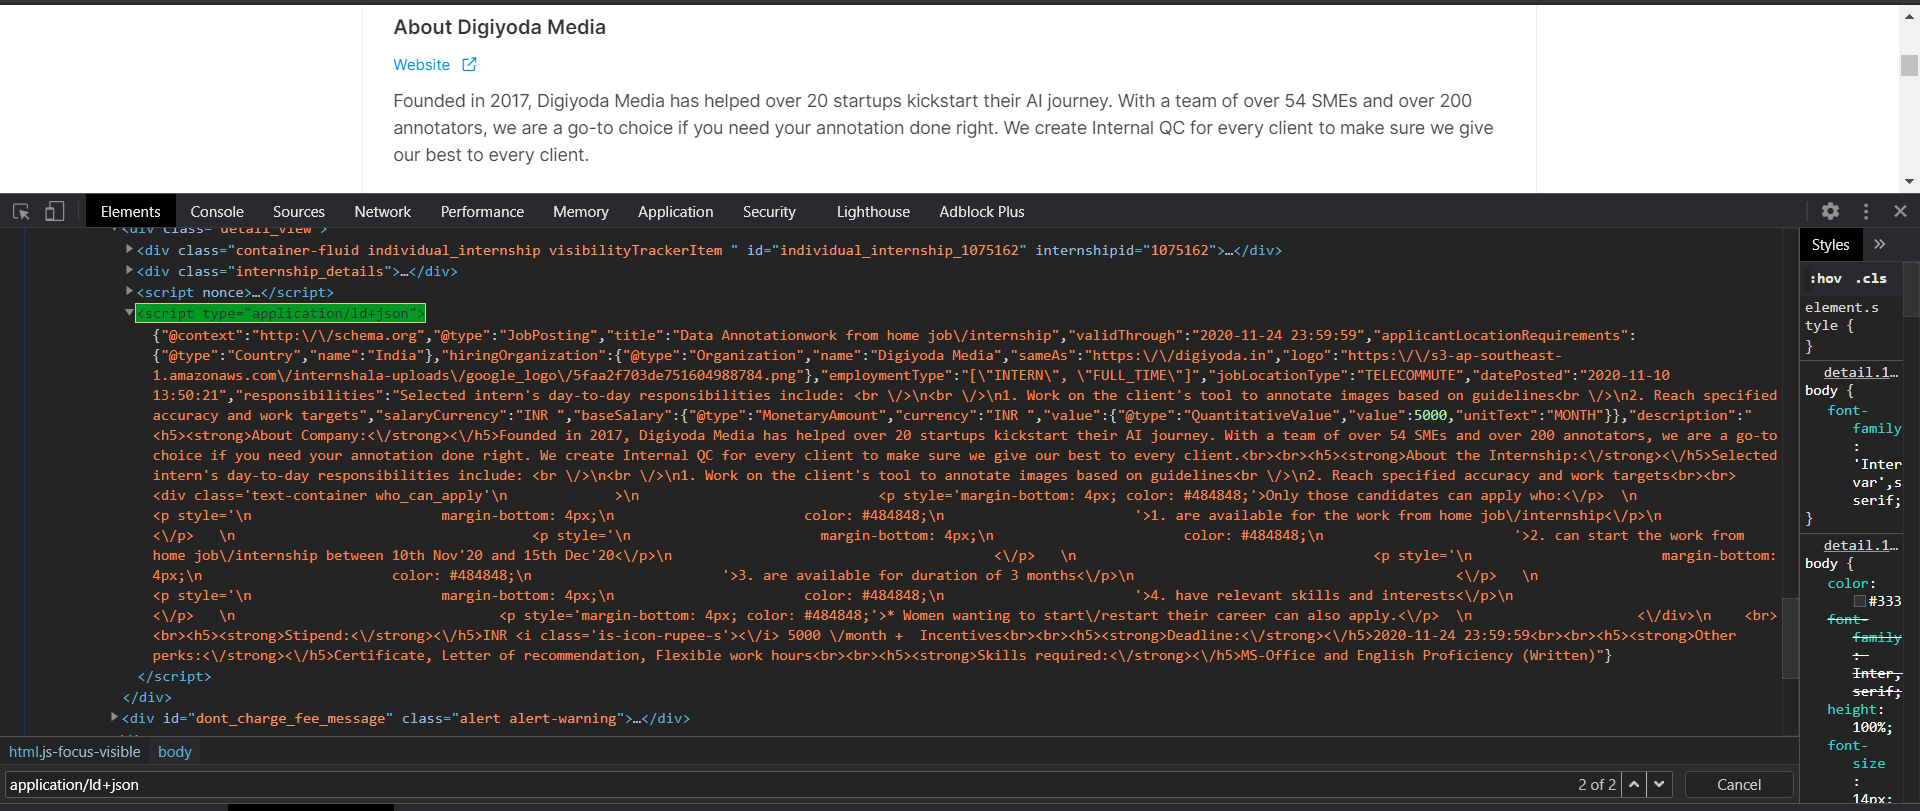

In [33]:
Image(data='3.png')

### Script tag with type as 'application/ld+json'  has description ,skills required embedded in html tags

In [38]:
#This function removes html tags from the text
def remove_html(text):
    lst=[]
    processed = re.sub(re.compile('<[^>]+>|\n'),' ', text)
    return processed

In [66]:
def get_words_from_links(lst):
    words_desc_list = [] 
    skills_list = []
    stipend_list = []
    paid_intern_links = []
    
    for link in lst:
        #Extracting description
        data = requests.get(link)
        soup = BeautifulSoup(data.text,'lxml')
        
        raw = soup.find_all('script',{'type':'application/ld+json'})[1].contents[0]
        js = json.loads(raw)['description'] #dumping the script as json as it is easier to access
        
        words = remove_html(js)
        words_desc_list.extend(words.lower().strip().split()) #appending all description words to a list
        
        # Extracting skills required from the script text 
        try:
            skills = re.search('Skills required:.+',words).group()
            skills_list.extend(skills.lower().strip().split()) #appending skills required to a list
        except:
            pass
        
        
        
        #Extracting stipend from span tag which has class as 'stipend'
        stipend = soup.find_all('span',{'class':'stipend'})[0].get_text().strip()
        lst = [] #This list is for storing only integer INR amount as some interns are unpaid hence discarding them
        
        for i in re.split('-|/',stipend): #Here '-' is used to split since some stipend is displayed as '5000-7000'
            try:
                int(i)
                lst.append(int(i))
            except:
                pass
    
        
        if len(lst) != 0: #lst with len '0' is unpaid intern
            
            #Since some stipend is displayed as range thus taking their mean(Eg: for 5000-7000 taking 6000 as stipend )
            if len(lst) > 1:
                stipend_list.append(sum(lst)/2)
            else:
                stipend_list.extend(lst)
        
            paid_intern_links.append(link)

            
        
    return words_desc_list,skills_list,stipend_list,paid_intern_links

In [67]:
words_desc_list,skills_list,stipend_list,paid_intern_links = get_words_from_links(interns)

## Wordclouds

*Stopwords are the words that occurs frequently in text such as - 'the','a'*<br/>
*Also i added some words which was very frequent in the texts such as 'internship' ,'certificate' etc*

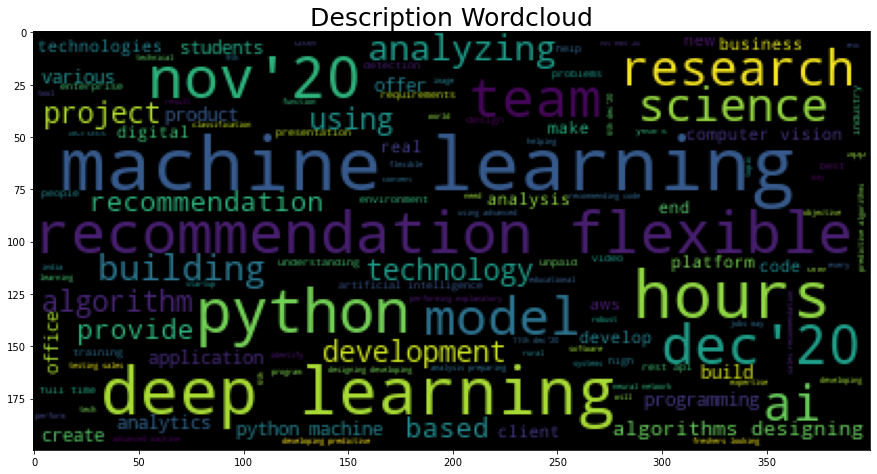

In [42]:
stopwords = list(STOPWORDS) + ['available','home','job','internship','work','skills','other','perks','candidates','certificate','start','selected','intern','required','duration','apply','responsibilities','duration','stipend','inr','company','interest','working','month','deadline','interests','include','day','relevant','restart','months','women','wanting','days','week','wanting','career','letter','solution','data','solutions']
joined_desc_sentences = ' '.join(words_desc_list)
wordcloud = WordCloud(stopwords=stopwords).generate(joined_desc_sentences)
plt.figure(figsize=(15,8), facecolor = None)
plt.title('Description Wordcloud',fontdict=dict(fontsize=25))
_=plt.imshow(wordcloud)

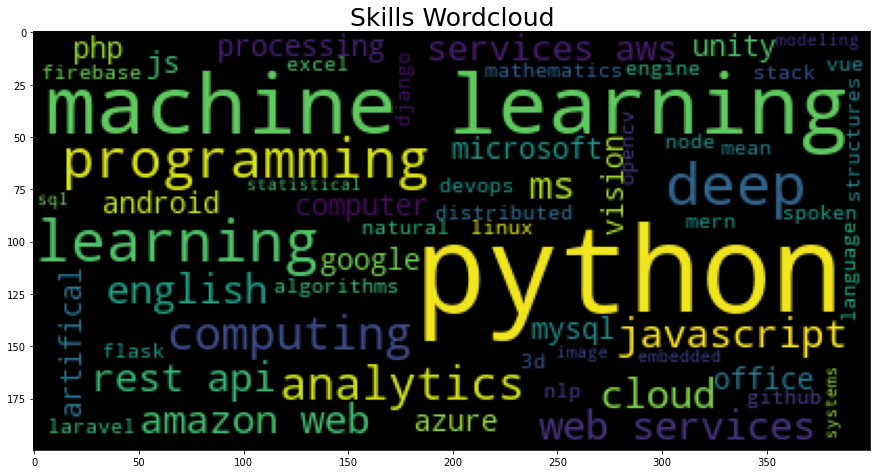

In [44]:
#stopwords = list(STOPWORDS) + ['available','home','job','internship','work','skills','other','perks','candidates','certificate','start','selected','intern','required','duration','apply','responsibilities','duration','stipend','inr','company','interest','working','month','deadline','interests','include','day','relevant','restart','months','women','wanting','days','week','wanting','career','letter','solution','data','solutions']
stopwords2 = stopwords+['proficiency','science','written','intelligence']
joined_skills_sentences = ' '.join(skills_list)
wordcloud = WordCloud(stopwords=stopwords2).generate(joined_skills_sentences)
plt.figure(figsize=(15,8), facecolor = None)
plt.title('Skills Wordcloud',fontdict=dict(fontsize=25))
_=plt.imshow(wordcloud)

## Stipend

In [58]:
print(f'There are {len(stipend_list)} paid internships and {len(interns) - len(stipend_list)} unpaid interships' )

There are 24 paid internships and 5 unpaid interships


In [49]:
print(f'Average stipend amount is INR {int(sum(stipend_list)/len(stipend_list))}')

Average stipend amount is INR 6302


In [90]:
#Dataframe for paid interns along with the links and respective stipend
pd.set_option('display.max_colwidth',300)
pd.DataFrame(list(zip(paid_links,stipend_list)),columns=['Link','Stipend'])


,Link,Stipend
0,https://internshala.com/internship/detail/machine-learning-and-cloud-computing-work-from-home-job-internship-at-iit-bombay1604739017,3000.0
1,https://internshala.com/internship/detail/data-annotation-work-from-home-job-internship-at-digiyoda-media1604989404,5000.0
2,https://internshala.com/internship/detail/deep-learning-research-for-algo-trading-work-from-home-job-internship-at-crowd-wisdom-trading1604990864,2000.0
3,https://internshala.com/internship/detail/conversational-application-implementation-internship-in-bangalore-at-wizergos1604980249,15000.0
4,https://internshala.com/internship/detail/php-laravel-development-work-from-home-job-internship-at-job-vacancy-result1604928142,1000.0
5,https://internshala.com/internship/detail/machine-learning-work-from-home-job-internship-at-pikkal-company1604917043,10000.0
6,https://internshala.com/internship/detail/machine-learning-internship-in-pune-at-kukbit-software-lab1604836598,4000.0
7,https://internshala.com/internship/detail/natural-language-processing-nlp-work-from-home-job-internship-at-koireader-technologies1604729616,7500.0
8,https://internshala.com/internship/detail/machine-learning-ai-work-from-home-job-internship-at-devincept1604715442,5000.0
9,https://internshala.com/internship/detail/ai-ml-computer-vision-robotics-part-time-job-internship-at-chennai-bangalore-in-alphabt1604664448,5000.0
